In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import scanpy as sc,anndata as ad
import squidpy as sq
import os
import re
import sys
from scipy.sparse import vstack
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,scale
from scipy.spatial import distance_matrix, distance
from sklearn.neighbors import KernelDensity
from scipy.spatial import KDTree
from scipy.spatial.distance import cdist
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
from sklearn.neighbors import BallTree
import time
import rdata
from scipy.sparse import csr_matrix,bsr_matrix,coo_matrix,issparse,lil_matrix,diags
from scipy.sparse.linalg import inv
import scipy as sp
from  scipy.ndimage import gaussian_filter
import igraph as ig
import glasbey
import warnings
import cairocffi as cairo
from sklearn.metrics import adjusted_rand_score,make_scorer
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn import preprocessing
import libpysal
from esda.losh import LOSH
from multiprocessing import Pool
from mclustpy import mclustpy
from sklearn.cluster import KMeans
import torch
#from GraphST import GraphST
import SEDR
#from GraphST.utils import clustering
from matplotlib.colors import ListedColormap
from esda import Moran
from libpysal.weights import KNN
from scsampler import scsampler 
from geosketch import gs
from scvalue import SCValue
from tqdm import tqdm
from fbpca import pca
from annoy import AnnoyIndex
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import mean_squared_error
from numpy.linalg import norm 

/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/envs/miniconda3/envs/r-kernel/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [3]:
def geo_coord_index(adata,fraction =0.1,seed =0): 
    N =int(fraction * adata.X.shape[0])
    geo_coord_index = gs(adata.obsm['spatial'], N, seed=seed, replace=False)
    return geo_coord_index
def geo_transcriptomic_index(adata,fraction = 0.1,seed = 0):
    N =int(fraction * adata.X.shape[0])
    geo_transcriptomic_index = gs(adata.obsm['X_pca'], N, seed=seed, replace=False)
    return geo_transcriptomic_index

def geo_coord_shuffled_index(adata,fraction = 0.1, seed = 0):
    N =int(fraction * adata.X.shape[0])
    coords = adata.obsm['spatial']
    shuffled_coords = shuffle_coordinates(coords,seed = seed)
    geo_coord_shuffled_index = gs(shuffled_coords,N,seed = seed,replace = False)
    return geo_coord_shuffled_index
    
def scsampler_coord_index(adata,fraction = 0.1,seed = 0):
    res = scsampler(adata.obsm['spatial'], fraction=fraction, random_state=seed, copy=True,random_split = 16)
    scsampler_transcptomic_index = res[1]
    return sorted(list(scsampler_transcptomic_index))

def scsampler_transcriptomics_index(adata,fraction = 0.1,seed = 0):
    res = scsampler(adata.obsm['X_pca'], fraction=fraction, random_state=seed, copy=True,random_split = 16)
    return sorted(list(res[1]))


def scsampler_coord_shuffled_index(adata,fraction = 0.1,seed = 0):
    coords = adata.obsm['spatial']
    shuffled_coords = shuffle_coordinates(coords,seed = seed)
    res = scsampler(shuffled_coords,fraction = fraction,random_state = seed,copy = True,random_split = 16)
    return sorted(list(res[1]))

def uniform_index(adata,fraction = 0.1,seed = 0):
    np.random.seed(seed)
    num_cells = adata.n_obs
    sample_size = int(num_cells*fraction)
    sampled_indices = np.random.choice(adata.obs.index,size = sample_size,replace = False)
    return sorted(list(sampled_indices))



def shuffle_coordinates(coordinates,seed = 0):
    """Shuffles pairs of coordinates in a NumPy array.

    Args:
        coordinates (numpy.ndarray): An array of shape (N, 2) 
                                     where N is the number of coordinate pairs.

    Returns:
        numpy.ndarray: A new array with shuffled coordinate pairs.
    """
    rng = np.random.default_rng(seed = seed)
    shuffled_indices = rng.permutation(coordinates.shape[0])
    shuffled_coordinates = coordinates[shuffled_indices]
    return shuffled_coordinates



def leverage_index(adata,fraction = 0.1,score_column="gene_score",seed = 0):
    #print("running leverage sampling")
    np.random.seed(seed)

    if score_column not in adata.obs:
        raise ValueError(f"Column '{score_column}' not found in adata.obs")

    scores = adata.obs[score_column].values
    # scores = np.clip(scores, a_min=0, a_max=None)  # Ensure no negative values
    probabilities = scores / scores.sum()  # Normalize to get probabilities

    num_cells = adata.n_obs
    sample_size = int(num_cells * fraction)

    sampled_indices = np.random.choice(adata.n_obs, size=sample_size, replace=False, p=probabilities)
    return sorted(list(sampled_indices))

def create_leverage_index_dataframe(adata, fraction=0.1, num_seeds=10, start_seed=0):
    """
    Creates a DataFrame where each column contains the sorted indices from uniform_index
    for a different random seed.
    
    Args:
        adata: AnnData object to sample from
        fraction (float): Fraction of cells to sample
        num_seeds (int): Number of different seeds to use
        start_seed (int): Starting seed value
        
    Returns:
        pandas.DataFrame: DataFrame with columns named 'seed_{seed}' containing sorted indices
    """
    # Dictionary to store results
    results = {}
    
    # Run uniform_index for each seed
    for seed in range(start_seed, start_seed + num_seeds):
        column_name = f'seed_{seed}'
        indices = get_leverage_index(adata, fraction=fraction, seed=seed)
        results[column_name] = indices
    
    # Create DataFrame from results
    # Note: Columns might have different lengths, so we'll use a different approach
    df_dict = {}
    
    # Find the maximum length of any index list
    max_length = max(len(indices) for indices in results.values())
    
    # Pad shorter lists with NaN values
    for column_name, indices in results.items():
        # Pad with NaN if needed
        padded_indices = indices + [np.nan] * (max_length - len(indices))
        df_dict[column_name] = padded_indices
    
    # Create DataFrame
    result_df = pd.DataFrame(df_dict)
    
    return result_df


In [5]:
directory = "/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/xenium_lung/raw_data"
adata = sc.read_h5ad(os.path.join(directory,"healthy_lung_unprocessed.h5ad"))

In [3]:
adata

AnnData object with n_obs × n_vars = 295883 × 541
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_id', 'reason_of_inclusion', 'Ensembl ID', 'in_panel'
    uns: 'spots'

In [6]:
sc.pp.calculate_qc_metrics(adata, percent_top=(10, 20, 50, 150), inplace=True)

In [7]:
cprobes = (
    adata.obs["control_probe_counts"].sum() / adata.obs["total_counts"].sum() * 100
)
cwords = (
    adata.obs["control_codeword_counts"].sum() / adata.obs["total_counts"].sum() * 100
)
print(f"Negative DNA probe count % : {cprobes}")
print(f"Negative decoding count % : {cwords}")


Negative DNA probe count % : 0.002703036139293321
Negative decoding count % : 0.002750157213036945


<Axes: title={'center': 'Nucleus ratio'}, ylabel='Count'>

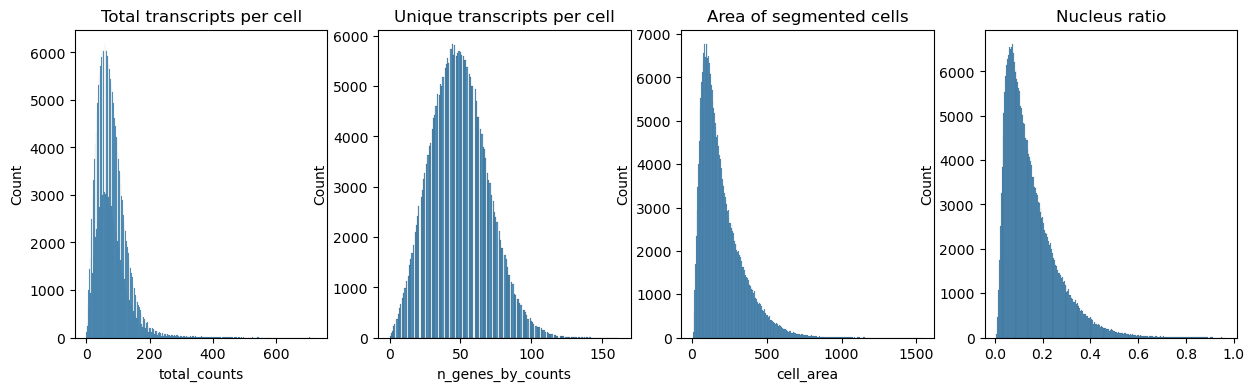

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    adata.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)


axs[2].set_title("Area of segmented cells")
sns.histplot(
    adata.obs["cell_area"],
    kde=False,
    ax=axs[2],
)

axs[3].set_title("Nucleus ratio")
sns.histplot(
    adata.obs["nucleus_area"] / adata.obs["cell_area"],
    kde=False,
    ax=axs[3],
)

In [9]:
sc.pp.filter_cells(adata, min_counts=10)
sc.pp.filter_genes(adata, min_cells=5)

In [10]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.tl.louvain(adata)

2025-03-20 14:40:53.125219: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-20 14:40:53.136828: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-20 14:40:53.140272: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-20 14:40:53.151262: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-20 14:41:00.761747: W tensorflow/compiler/tf2

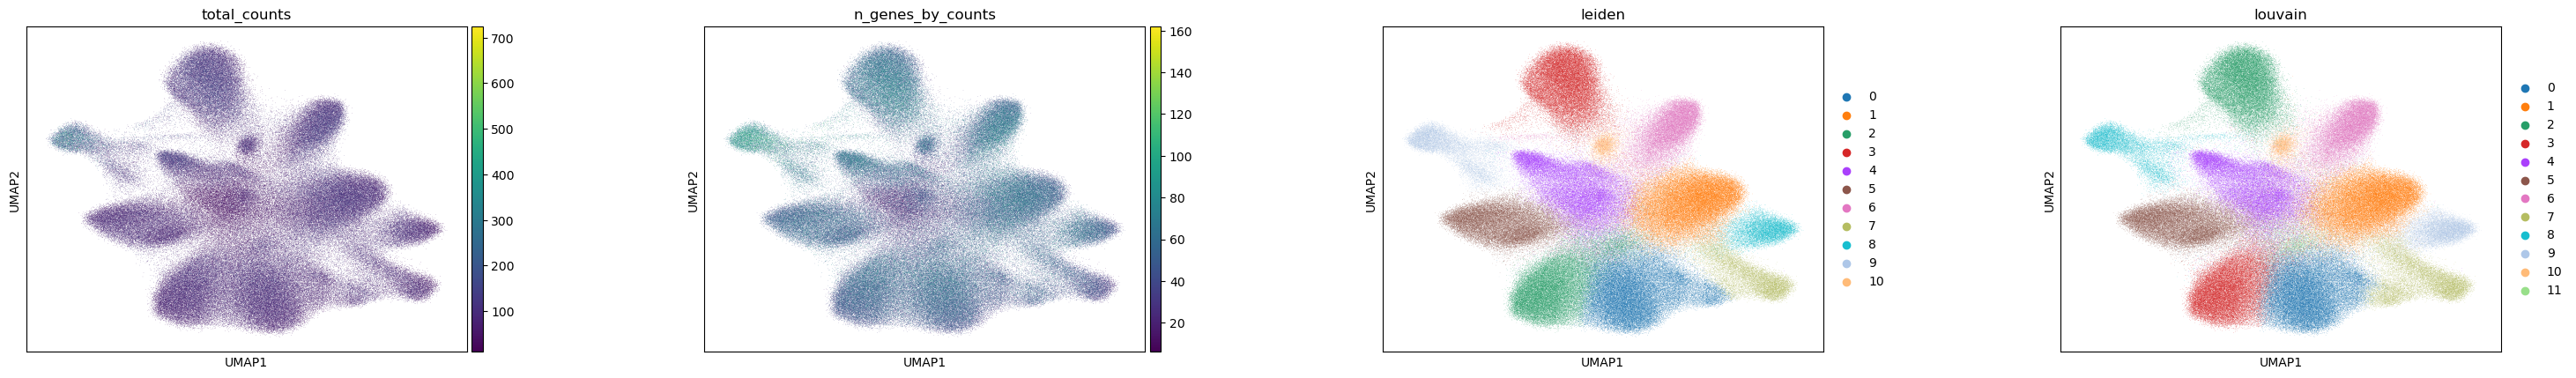

In [11]:
sc.pl.umap(
    adata,
    color=[
        "total_counts",
        "n_genes_by_counts",
        "leiden","louvain"
    ],
    wspace=0.4,
)


In [12]:
centroids = adata.obs[['x_centroid', 'y_centroid']].to_numpy()
centroids[:, 1] *= -1  # Multiply the y-coordinates by -1
adata.obsm['spatial'] = centroids

/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/envs/miniconda3/envs/r-kernel/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/envs/miniconda3/envs/r-kernel/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


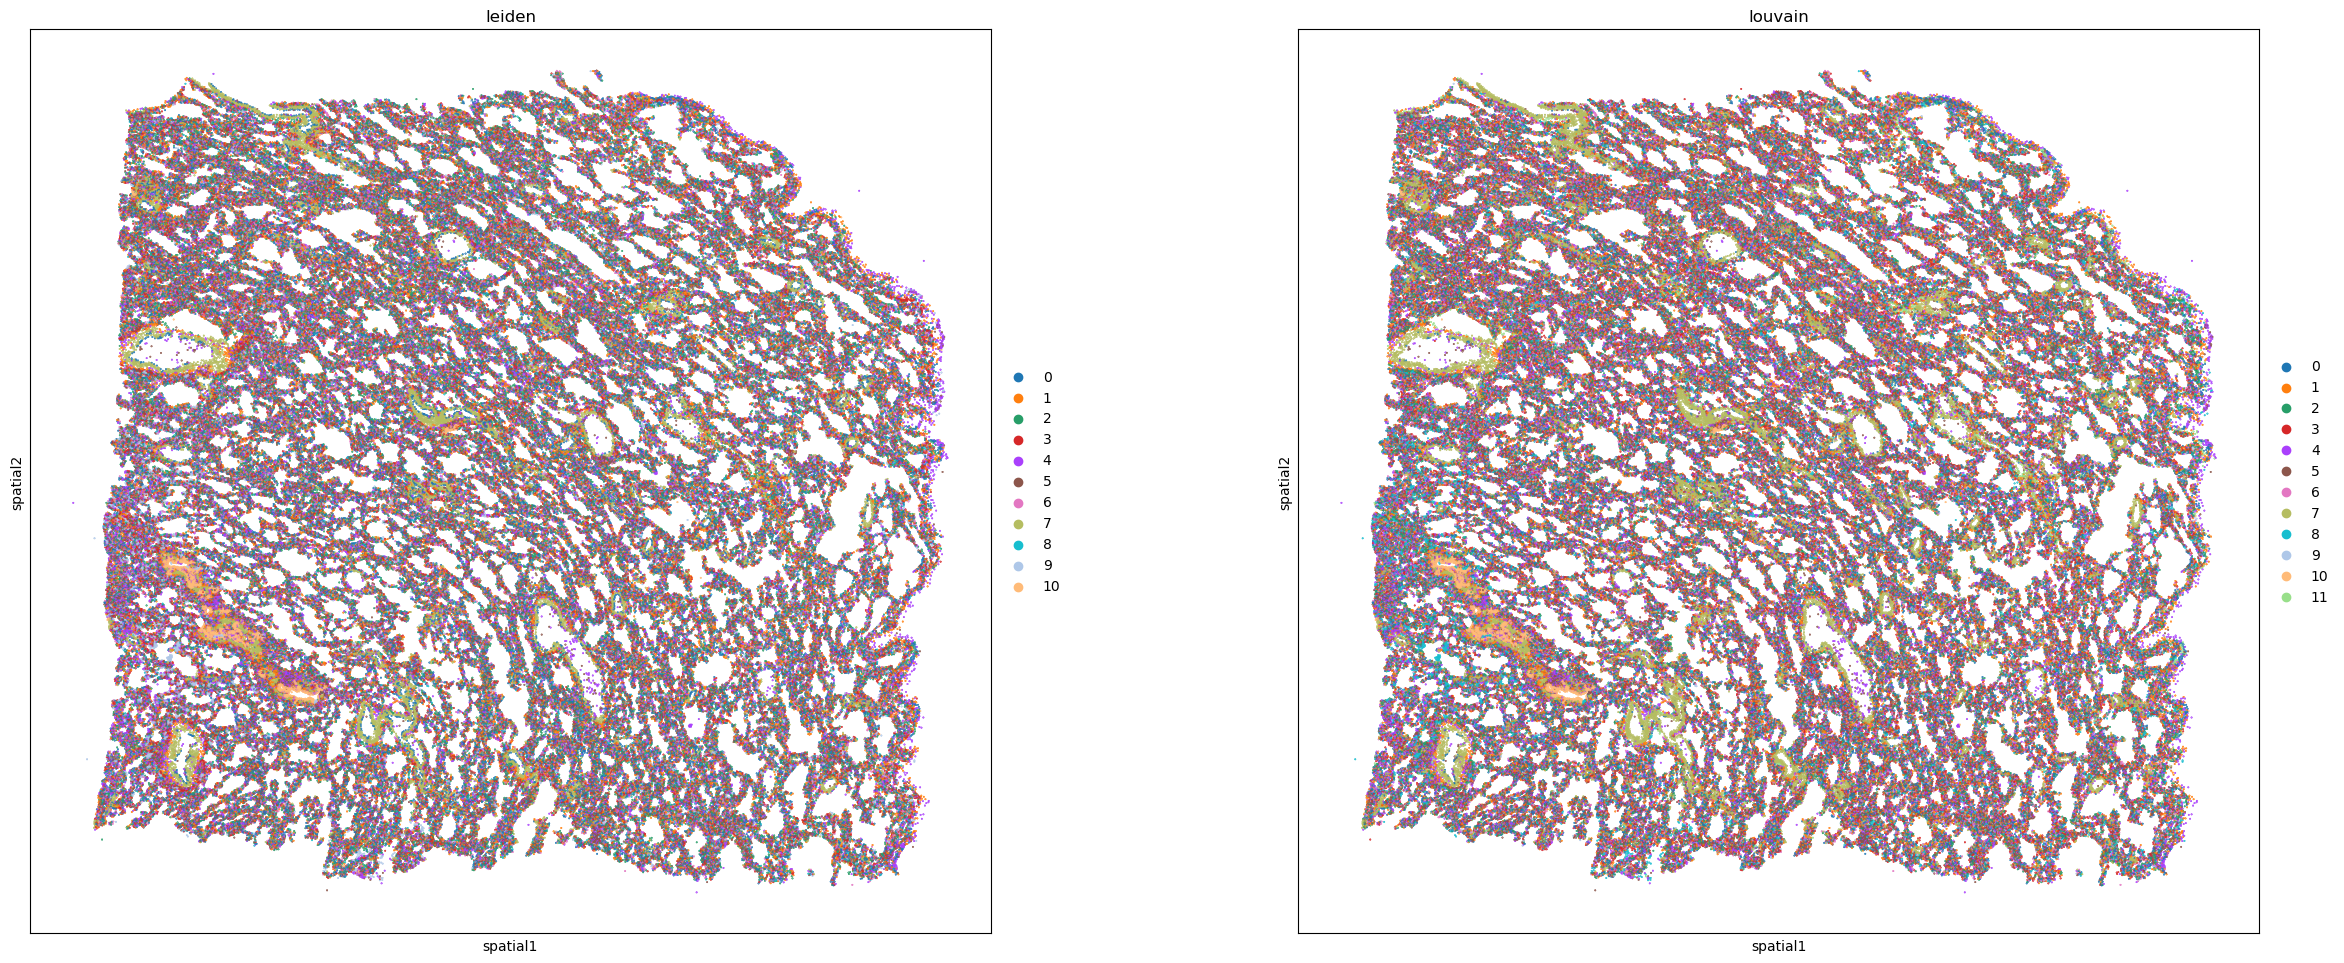

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(30, 30))  # Create subplots for two colors

sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    color=["leiden", "louvain"],
    wspace=0.4,
    fig=fig,  # Explicitly pass the figure object
    ax=axes   # Pass list of axes
)

plt.show()

In [14]:
#build neighborhood graph: 
sq.gr.spatial_neighbors(adata, coord_type="generic", n_neighs = 10)


In [15]:
sq.gr.centrality_scores(adata, cluster_key="louvain")

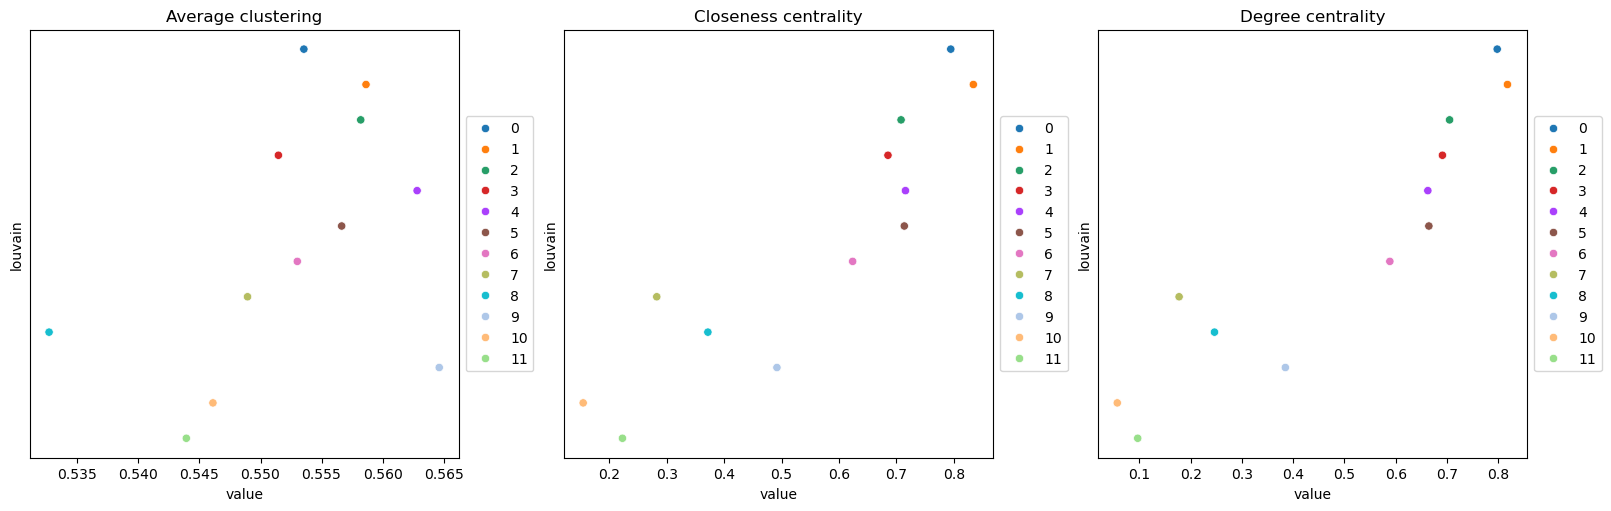

In [16]:
sq.pl.centrality_scores(adata, cluster_key="louvain", figsize=(16, 5))

In [35]:
#compute co-occurance probability 
adata

AnnData object with n_obs × n_vars = 292908 × 515
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden', 'louvain'
    var: 'gene_id', 'reason_of_inclusion', 'Ensembl ID', 'in_panel', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spots', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'louvain', 'leiden_colors', 'louvain_colors', 'spatial_neighbors', 'louvain_centrality_scores'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities', 'spatial_connectivities', 'spatial_distances'

In [40]:
# sq.gr.co_occurrence(
#     adata,
#     cluster_key="louvain",
# )


In [ ]:
adata

In [41]:
#save just a counts version of the object 
adata_counts_only = ad.AnnData(adata.X)
adata_counts_only.write_h5ad("/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/xenium_lung/processed_data/xenium_lung_counts_only.h5ad")


In [ ]:
sq.pl.co_occurrence(
    adata,
    cluster_key="louvain",
    clusters="12",
    figsize=(10, 10),
)

In [17]:
#now lets do a neighborhood enrichment: 
sq.gr.nhood_enrichment(adata, cluster_key="louvain")

  0%|          | 0/1000 [00:00<?, ?/s]

/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/envs/miniconda3/envs/r-kernel/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


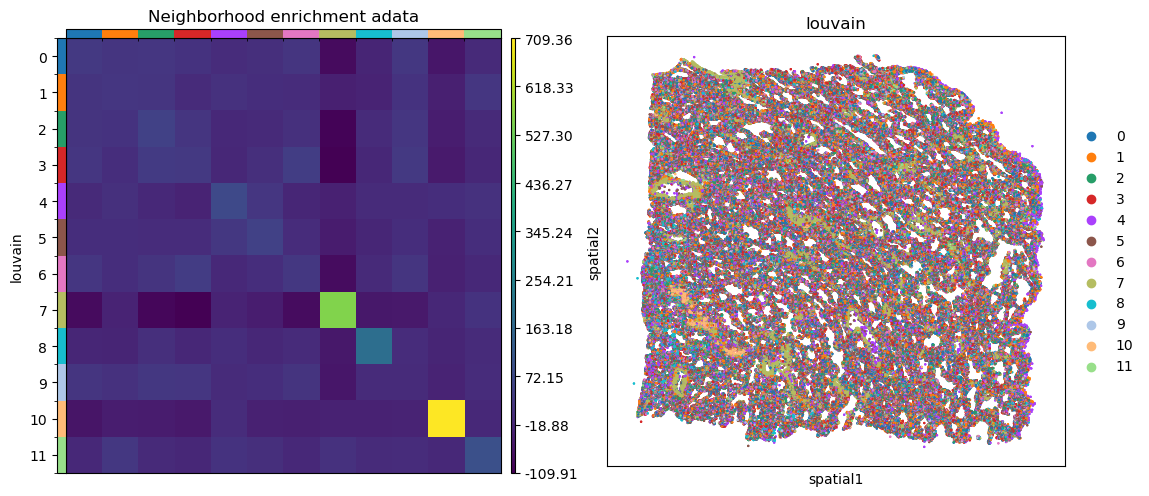

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(13, 7))
sq.pl.nhood_enrichment(
    adata,
    cluster_key="louvain",
    figsize=(8, 8),
    title="Neighborhood enrichment adata",
    ax=ax[0],
)
sq.pl.spatial_scatter(adata, color="louvain", shape=None, size=2, ax=ax[1])

In [49]:
np.shape(adata.uns['louvain_nhood_enrichment']['zscore'])

(12, 12)

In [21]:
seed = 0
fraction = 0.1
gene_scores_df = pd.read_csv('/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/xenium_lung/processed_data/leverage_scores.csv')
adata.obs['gene_score'] = gene_scores_df['leverage_score'].values

parent_dir = '/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/xenium_lung/sketching_test/index'

sub_dirs = {
    'uniform_index': uniform_index,
    'leverage_index':leverage_index,
    'geo_coord_shuffled_index': geo_coord_shuffled_index,
    'scsampler_coord_shuffled_index':scsampler_coord_shuffled_index,
    'geo_coord_index': geo_coord_index,
    'geo_transcriptomic_index': geo_transcriptomic_index,
    'scsampler_coord_index': scsampler_coord_index,
    'scsampler_transcriptomic_index': scsampler_transcriptomics_index
}

 
for sub_dir, index_function in sub_dirs.items():
	result_lists = {f'seed_{seed}': []}  # Create an empty dictionary for results


	# You need to define `adata` appropriately (not shown)
	result = index_function(adata, fraction=fraction, seed=seed)
	result_lists[f'seed_{seed}'] = result  # Store result in the dictionary under the appropriate seed key

	# Create a DataFrame from the result lists
	df = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in result_lists.items()]))

	# Save DataFrame to CSV in corresponding subdirectory
	output_file_path = os.path.join(parent_dir, sub_dir, f'index_seed_{seed}_{fraction}.csv')
	df.to_csv(output_file_path, index=False)

	print(f'Results saved in {output_file_path}')

Results saved in /dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/xenium_lung/sketching_test/index/uniform_index/index_seed_0_0.1.csv
Results saved in /dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/xenium_lung/sketching_test/index/leverage_index/index_seed_0_0.1.csv
Results saved in /dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/xenium_lung/sketching_test/index/geo_coord_shuffled_index/index_seed_0_0.1.csv
Results saved in /dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/xenium_lung/sketching_test/index/scsampler_coord_shuffled_index/index_seed_0_0.1.csv
Results saved in /dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/xenium_lung/sketching_test/index/geo_coord_index/index_seed_0_0.1.csv
Results saved in /dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/xenium_lung/sketching_test/index/geo_transcriptomic_index/index_seed_0_0.1.csv
Results saved in /dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/xenium_lung/sketch

In [19]:
adata.write_h5ad("/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/xenium_lung/processed_data/xenium_lung_processed.h5ad")

In [2]:
adata = sc.read_h5ad("/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/xenium_lung/processed_data/xenium_lung_processed.h5ad")

In [3]:
#testing for the full metrics; 
#functions: 
def compute_cell_type_proportions_annoy(subset_adata, full_adata, ground_truth="Cell_Type", k=20, n_trees=10):
    """
    Computes the proportion of cell types in the neighborhood of each cell using Annoy.

    Parameters:
    - subset_adata: AnnData object with spatial coordinates for the subset dataset in `subset_adata.obsm`
    - full_adata: AnnData object representing the full dataset with all possible cell types
    - k: Number of nearest neighbors to consider
    - n_trees: Number of trees for Annoy (higher = better accuracy but slower)

    Returns:
    - A DataFrame of shape (n_cells, n_cell_types) with proportions of each cell type in its neighborhood, aligned with full dataset cell types.
    """
    # Extract spatial coordinates from subset adata
    coords = subset_adata.obsm["spatial"]
    n_cells, n_dims = coords.shape

    # Build Annoy index
    annoy_index = AnnoyIndex(n_dims, metric='euclidean')
    for i in range(n_cells):
        annoy_index.add_item(i, coords[i])
    annoy_index.build(n_trees)  # Build the index

    # Extract cell type labels from full adata
    full_cell_types = np.array(full_adata.obs[ground_truth])
    full_unique_types = np.unique(full_cell_types)  # Full unique cell types
    type_to_idx = {t: i for i, t in enumerate(full_unique_types)}  # Mapping cell type to column index

    # Initialize output matrix
    proportions = np.zeros((n_cells, len(full_unique_types)))

    # Extract cell type labels from subset adata
    subset_cell_types = np.array(subset_adata.obs[ground_truth])

    # Compute kNN for each cell in subset adata
    for i in range(n_cells):
        neighbors = annoy_index.get_nns_by_item(i, k+1)[1:]  # Exclude self
        neighbor_types = subset_cell_types[neighbors]  # Get cell types of kNN
        # Count occurrences of each cell type
        for t in neighbor_types:
            proportions[i, type_to_idx[t]] += 1
        proportions[i] /= k  # Normalize to proportions

    # Convert to DataFrame with full unique cell types as columns
    prop_df = pd.DataFrame(proportions, columns=full_unique_types, index=subset_adata.obs.index)
    return prop_df


def get_leverage_index(adata,fraction = 0.1,score_column="gene_score",seed = 0):
    #print("running leverage sampling")
    np.random.seed(seed)

    if score_column not in adata.obs:
        raise ValueError(f"Column '{score_column}' not found in adata.obs")

    scores = adata.obs[score_column].values
    # scores = np.clip(scores, a_min=0, a_max=None)  # Ensure no negative values
    probabilities = scores / scores.sum()  # Normalize to get probabilities

    num_cells = adata.n_obs
    sample_size = int(num_cells * fraction)

    sampled_indices = np.random.choice(adata.n_obs, size=sample_size, replace=False, p=probabilities)
    return sorted(list(sampled_indices))

def create_leverage_index_dataframe(adata, fraction=0.1, num_seeds=10, start_seed=0):
    """
    Creates a DataFrame where each column contains the sorted indices from uniform_index
    for a different random seed.
    
    Args:
        adata: AnnData object to sample from
        fraction (float): Fraction of cells to sample
        num_seeds (int): Number of different seeds to use
        start_seed (int): Starting seed value
        
    Returns:
        pandas.DataFrame: DataFrame with columns named 'seed_{seed}' containing sorted indices
    """
    # Dictionary to store results
    results = {}
    
    # Run uniform_index for each seed
    for seed in range(start_seed, start_seed + num_seeds):
        column_name = f'seed_{seed}'
        indices = get_leverage_index(adata, fraction=fraction, seed=seed)
        results[column_name] = indices
    
    # Create DataFrame from results
    # Note: Columns might have different lengths, so we'll use a different approach
    df_dict = {}
    
    # Find the maximum length of any index list
    max_length = max(len(indices) for indices in results.values())
    
    # Pad shorter lists with NaN values
    for column_name, indices in results.items():
        # Pad with NaN if needed
        padded_indices = indices + [np.nan] * (max_length - len(indices))
        df_dict[column_name] = padded_indices
    
    # Create DataFrame
    result_df = pd.DataFrame(df_dict)
    
    return result_df

def uniform_sample_adata(adata, fraction=0.1, random_state=None):
    """
    Uniformly samples a fraction of cells from an AnnData object.
    
    Parameters:
    - adata: AnnData object
    - fraction: float, fraction of cells to sample (default is 10%)
    - random_state: int, random seed for reproducibility (default is None)
    
    Returns:
    - AnnData object with sampled cells
    """
    print("running uniform sampling")
    np.random.seed(random_state)
    num_cells = adata.n_obs  # Total number of cells
    sample_size = int(num_cells * fraction)  # Compute number of cells to sample

    sampled_indices = np.random.choice(adata.obs.index, size=sample_size, replace=False)
    
    return adata[sampled_indices].copy()  # Return a new AnnData object


def compare_cell_type_proportions(matrix1, matrix2):
    """
    Computes cosine similarity, Jensen-Shannon Divergence (JSD), Mean Squared Error (MSE),
    and Frobenius norm between two cell type proportion matrices.

    Parameters:
    - matrix1: pandas DataFrame (n_cells x n_cell_types), first cell type proportion matrix
    - matrix2: pandas DataFrame (n_cells x n_cell_types), second cell type proportion matrix

    Returns:
    - results: dict with 'mean_cosine_similarity', 'mean_jsd', 'mse', and 'frobenius_norm'
    """
    if matrix1.shape != matrix2.shape:
        raise ValueError("Both matrices must have the same shape.")
    
    # Initialize results with NaN
    results = {
        "mean_cosine_similarity": np.nan,
        "mean_jsd": np.nan,
        "mse": np.nan,
        "frobenius_norm": np.nan
    }

    # Compute Cosine Similarity (mean across all cells) and handle memory issues
    try:
        cos_sim = cosine_similarity(matrix1, matrix2)
        results["mean_cosine_similarity"] = np.mean(np.diag(cos_sim))  # Take mean of diagonal elements (self-similarity)
    except MemoryError:
        print("MemoryError encountered during cosine similarity calculation. Calculating manually.")
        try:
            cos_sim_values = []
            for i in range(matrix1.shape[0]):
                vec1 = matrix1.iloc[i].values
                vec2 = matrix2.iloc[i].values
                dot_product = np.dot(vec1, vec2)
                norm1 = np.linalg.norm(vec1)
                norm2 = np.linalg.norm(vec2)
                
                if norm1 > 0 and norm2 > 0:
                    cos_sim_values.append(dot_product / (norm1 * norm2))
                else:
                    cos_sim_values.append(0)  # Handle zero vector case
            
            results["mean_cosine_similarity"] = np.mean(cos_sim_values)
        except Exception as e:
            print(f"An unexpected error occurred during manual cosine similarity calculation: {e}")

    # Compute Jensen-Shannon Divergence (JSD) and handle memory issues
    try:
        jsd_values = [jensenshannon(matrix1.iloc[i], matrix2.iloc[i]) for i in range(len(matrix1))]
        results["mean_jsd"] = np.mean(jsd_values)
    except MemoryError:
        print("MemoryError encountered during JSD calculation. Returning NaN.")
    except Exception as e:
        print(f"An unexpected error occurred during JSD calculation: {e}")

    # Compute Mean Squared Error (MSE) and handle memory issues
    try:
        results["mse"] = mean_squared_error(matrix1, matrix2)
    except MemoryError:
        print("MemoryError encountered during MSE calculation. Returning NaN.")
    except Exception as e:
        print(f"An unexpected error occurred during MSE calculation: {e}")

    # Compute Frobenius Norm and handle memory issues
    try:
        results["frobenius_norm"] = norm(matrix1.values - matrix2.values, 'fro')
    except MemoryError:
        print("MemoryError encountered during Frobenius Norm calculation. Returning NaN.")
    except Exception as e:
        print(f"An unexpected error occurred during Frobenius Norm calculation: {e}")

    return results
def compute_neighborhood_metrics(adata, fraction=0.1, seed=0, k=20, ground_truth="Cell_Type", n_trees=10):
    """
    Evaluates four sampling methods by computing cell type proportions and comparing them to the full dataset.

    Parameters:
    - adata: AnnData object
    - fraction: float, fraction of cells to sample
    - seed: int, random seed for reproducibility
    - k: int, number of nearest neighbors for Annoy
    - ground_truth: str, column in `adata.obs` containing cell type labels
    - n_trees: int, number of trees for Annoy index

    Returns:
    - A DataFrame containing similarity metrics for each sampling method
    """
    start_time = time.time()
    # Compute full dataset cell type proportions
    print("Computing cell type proportions for full dataset...")
    cell_type_proportions_full = compute_cell_type_proportions_annoy(adata, adata,ground_truth = ground_truth)

    # Generate sampled indices using different methods
    print("Generating sampled indices...")
    sampled_indices = sampling_methods_get_index(adata,fraction=fraction, seed=seed)
    results = {}

    for method, indices in sampled_indices.items():
        print(f"Processing {method}...")
        # Compute cell type proportions for subsampled data
        sampled_adata = adata[indices]
        cell_type_proportions_sub = compute_cell_type_proportions_annoy(sampled_adata, adata,ground_truth = ground_truth)

        # Extract corresponding subset from full dataset
        cell_type_proportions_full_partial = cell_type_proportions_full.loc[adata.obs.index[indices]]

        # Compute similarity metrics
        metrics = compare_cell_type_proportions(cell_type_proportions_sub, cell_type_proportions_full_partial)
        
        # Store metrics
        results[method] = metrics

    # Convert results dictionary to DataFrame
    results_df = pd.DataFrame.from_dict(results,orient = 'index').reset_index()
    results_df.rename(columns = {results_df.columns[0]:'method'},inplace = True)

    print(f"Evaluation completed in {time.time() - start_time:.2f} seconds.")
    return results_df



def load_csv_by_fraction(directory, target_fraction= 0):
    """
    Walks through a directory to find and load a CSV file with a matching fraction in its name.
    
    Args:
        directory (str): Path to the directory containing CSV files
        target_fraction (float): The fraction to match in the filename (between 0.0 and 1.0)
        
    Returns:
        pandas.DataFrame: DataFrame containing the CSV data, or None if no matching file is found
    """
    # Convert target_fraction to string for comparison
    target_str = str(target_fraction)
    
    # Pattern to match index_fraction.csv files
    pattern = re.compile(r'index_(0?\.\d+)\.csv$')
    
    for root, _, files in os.walk(directory):
        for file in files:
            match = pattern.match(file)
            if match:
                file_fraction = match.group(1)
                
                # Compare fractions (accounting for different string representations)
                if float(file_fraction) == float(target_fraction):
                    file_path = os.path.join(root, file)
                    print(f"Found matching file: {file_path}")
                    return pd.read_csv(file_path)
    
    print(f"No CSV file found with fraction {target_fraction}")
    return None



def generate_uniform_index_df(adata, fraction=0.1, random_seeds = range(10)):
    """
    Generate a DataFrame containing indices of uniformly sampled subsets of the AnnData object.

    :param adata: The AnnData object to sample from.
    :param fraction: The fraction of data to sample in each iteration.
    :param random_seeds: A list of random seeds for reproducibility in each sampling iteration.
    :return: A DataFrame where each column represents the indices of a sampled subset.
    """
    # Validate inputs
    if not 0 < fraction <= 1:
        raise ValueError("The fraction must be between 0 and 1.")
    
    num_samples = len(adata)
    num_subsamples = len(random_seeds)  # Should be 10 based on your example
    
    # DataFrame to store index results
    uniform_index_df = pd.DataFrame()
    
    for i, seed in enumerate(random_seeds):
        # Set the random seed
        np.random.seed(seed)
        
        # Determine the number of samples for this fraction
        sample_size = int(num_samples * fraction)
        
        # Sample indices
        sampled_indices = sorted(np.random.choice(adata.n_obs, size=sample_size, replace=False))
        
        # Add sampled indices to DataFrame as a new column
        uniform_index_df[f'seed_{i}'] = pd.Index(sampled_indices)
    
    return uniform_index_df


def partial_hausdorff_distance_annoy(array1, array2, q=1e-4, metric='euclidean', n_trees=10):
    """
    Compute the partial Hausdorff distance from array1 to array2 using Annoy for approximation.
    
    Parameters:
    - array1: numpy.ndarray, shape (n, d)
        The first array of points.
    - array2: numpy.ndarray, shape (m, d)
        The second array of points.
    - q: float, optional
        The parameter for the partial Hausdorff distance, should be between 0 and 1.
    - metric: string, optional
        The metric to use for distance calculations. Annoy supports 'euclidean' and 'angular'.
    - n_trees: int, optional
        Number of trees to use for Annoy's index construction.
    
    Returns:
    - float
        The estimated partial Hausdorff distance between array1 and array2.
    """
    # Build Annoy index for array2
    num_features = array2.shape[1]
    annoy_index = AnnoyIndex(num_features, metric)
    for i, vector in enumerate(array2):
        annoy_index.add_item(i, vector)
    print("building Annoy index")
    start = time.time()
    annoy_index.build(n_trees)
    end = time.time()
    print(f"Annoy index took {end-start:.4f} seconds to build")

    # Query for nearest neighbors
    print("finding nearest neighbors")
    start = time.time()
    distances = []
    for point in array1:
        nearest_idx, dist = annoy_index.get_nns_by_vector(point, 1, include_distances=True)
        distances.append(dist[0])
    end = time.time()
    print(f"ANN distance calculation took: {end-start:.4f} seconds")

    # Sort all computed distances
    distances.sort()
    # Determine the index of the Kth largest value for partial Hausdorff
    K = int(np.floor((1 - q) * len(distances)))
    # Handle edge cases and return the Kth largest value
    return distances[K-1] if K > 0 else distances[0]


def compute_full_metrics(adata,
	fraction = 0.1,
	seed = 0, 
	base_directory = "/test/dir", 
	ground_truth = 'celltype',
	knn_for_neighborhood_analysis = 10,
	n_neighbors_for_clustering = 10,
	cluster_algorithm = 'louvain',n_clusters = 15):


    method_index_dict = {
        "geo_coords":"geo_coord_index",
        "geo_coord_shuffled":"geo_coord_shuffled_index",
        "geo_transcriptomic":"geo_transcriptomic_index",
        "leverage":"leverage_index",
        "scsampler_coord":"scsampler_coord_index",
        "scsampler_coord_shuffled":"scsampler_coord_shuffled_index",
        "scsampler_transcriptomic":"scsampler_transcriptomic_index",
        "uniform":"uniform_index"
    }
    
    
    results = {}
    full_pca = PCA(n_components = 20, svd_solver = 'randomized',random_state = 2024)
    full_pca.fit(adata.X.toarray())
    
    #cell_type_proportions_full = compute_cell_type_proportions_annoy(adata, adata,ground_truth = ground_truth,k = knn_for_neighborhood_analysis)
    
    for method, child_dir in method_index_dict.items():
        if child_dir != "uniform_index":
            index_df = load_csv_by_fraction(os.path.join(base_directory,child_dir),target_fraction = fraction)
            #sort the columns for easier access next time: 
            index_df = index_df.reindex(columns = sorted(index_df.columns))
        elif child_dir == "uniform_index": 
            index_df = generate_uniform_index_df(adata,fraction = fraction,random_seeds = range(10))
        if method not in results:
            results[method] = {}
        
        
        column_name = f"seed_{seed}"
        if column_name in index_df.columns:
        	index_values = index_df[column_name].values
        	sampled_adata = adata[index_values]

        #next we will iterate over the rows of the dataframe to subsample. 
        #for column_name, index_values in index_df.items():
    
            #sampled_adata = adata[index_values.values]
    
            #neighborhood metrics: 
            # cell_type_proportions_sub = compute_cell_type_proportions_annoy(sampled_adata, adata,ground_truth = ground_truth,k = knn_for_neighborhood_analysis)
            # cell_type_proportions_full_partial = cell_type_proportions_full.loc[adata.obs.index[index_values.values]]
            # metrics = compare_cell_type_proportions(cell_type_proportions_sub, cell_type_proportions_full_partial)
            
            #now for the metrics: 
            #compute the cell type metrics 
            #comput the two distance metrics! 
        transcriptomic_distance=partial_hausdorff_distance_annoy(adata.X.toarray(), sampled_adata.X.toarray(), q=1e-4)
        coord_distance = partial_hausdorff_distance_annoy(adata.obsm['spatial'], sampled_adata.obsm['spatial'], q=1e-4)
        
        results[method]['transcriptomic_distance'] = transcriptomic_distance
        results[method]['coord_distance'] = coord_distance
                #now we need to calcualte 2 ARIs: The ARI on the full dataset PCA solution (subset)
        # and the ARI on the recomputed PCA solution. 
        #first lets do the original PCA clustering: 
        #note: only calculate the ARI values if seed==0, otherwise we won't need to recompute it. 
        #add nans to the ARi otherwise: 
        #seed = int(column_name.replace("seed_",""))
        if seed ==0:
            sc.pp.neighbors(sampled_adata, n_neighbors=n_neighbors_for_clustering, use_rep='X_pca')
            sampled_adata = RASP.clustering(sampled_adata, n_clusters=n_clusters, n_neighbors=n_neighbors_for_clustering, key='X_pca', method=cluster_algorithm)
    
            # Get true and predicted labels
            ground_truth_labels = sampled_adata.obs[ground_truth].astype(str)
            labels = sampled_adata.obs[f'RASP_{cluster_algorithm}_clusters'].astype(str)
    
            # Compute ARI
            ari_original_pca = adjusted_rand_score(ground_truth_labels, labels)
            results[method]['ari_original_pca'] = ari_original_pca
    
            #now we will re-compute the PCA and re-cluster. 
            pca_model_sketch = PCA(n_components=20, svd_solver='randomized', random_state=2024)
    
            pca_data = pca_model_sketch.fit_transform(sampled_adata.X)
            sampled_adata.obsm['X_pca_recomputed'] = pca_data
            sc.pp.neighbors(sampled_adata, n_neighbors=n_neighbors_for_clustering, use_rep='X_pca_recomputed')
            sampled_adata = RASP.clustering(sampled_adata, n_clusters=n_clusters, n_neighbors=n_neighbors_for_clustering, key='X_pca_recomputed', method=cluster_algorithm)
            labels = sampled_adata.obs[f'RASP_{cluster_algorithm}_clusters'].astype(str)
            ari_recomputed_pca = adjusted_rand_score(ground_truth_labels, labels)
            results[method]['ari_recomputed_pca'] = ari_recomputed_pca
        
        #Now for the PCA distances 
        S = sampled_adata.X.toarray()
        # full_pca = PCA(n_components = 20, svd_solver = 'randomized',random_state = 2024)
        # full_pca.fit(adata.X.toarray())
        P_f = full_pca.transform(S)
        # Project S onto PCs of sampled data (sampled_adata)
        sketch_pca = PCA(n_components=20, svd_solver='randomized', random_state=2024)
        sketch_pca.fit(S)
        P_s = sketch_pca.transform(S)

        #Step 5: compute euclidean distance between rows of P_f and P_s
        distances = np.linalg.norm(P_f-P_s,axis = 1)
        mean_distance = np.mean(distances)
        median_distance = np.median(distances)

        results[method]['pca_mean_diff'] = mean_distance
        results[method]['pca_median_diff'] = median_distance


        #save the other function parameters as well: seed, k, and fraction 
        results[method]['knn_for_neighborhood_analysis'] = knn_for_neighborhood_analysis
        results[method]['seed'] = seed
        results[method]['fraction'] = fraction
        # Convert results dictionary to DataFrame
    results_df = pd.DataFrame.from_dict(results,orient = 'index').reset_index()
    results_df.rename(columns = {results_df.columns[0]:'method'},inplace = True)
    return results_df

In [4]:
base_directory = '/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/xenium_lung/sketching_test/index'
fraction = 0.01
method_index_dict = {
        "geo_coords":"geo_coord_index",
        "geo_coord_shuffled":"geo_coord_shuffled_index",
        "geo_transcriptomic":"geo_transcriptomic_index",
        "leverage":"leverage_index",
        "scsampler_coord":"scsampler_coord_index",
        "scsampler_coord_shuffled":"scsampler_coord_shuffled_index",
        "scsampler_transcriptomic":"scsampler_transcriptomic_index",
        "uniform":"uniform_index"
    }
    
    
results = {}
full_pca = PCA(n_components = 20, svd_solver = 'randomized',random_state = 2024)
full_pca.fit(adata.X.toarray())

#cell_type_proportions_full = compute_cell_type_proportions_annoy(adata, adata,ground_truth = ground_truth,k = knn_for_neighborhood_analysis)

for method, child_dir in method_index_dict.items():
    if child_dir != "uniform_index":
        index_df = load_csv_by_fraction(os.path.join(base_directory,child_dir),target_fraction = fraction)
        #sort the columns for easier access next time: 
        index_df = index_df.reindex(columns = sorted(index_df.columns))
    elif child_dir == "uniform_index": 
        index_df = generate_uniform_index_df(adata,fraction = fraction,random_seeds = range(10))
    if method not in results:
        results[method] = {}
    
    
    column_name = f"seed_{seed}"
    if column_name in index_df.columns:
        index_values = index_df[column_name].values
        sampled_adata = adata[index_values]

No CSV file found with fraction 0.01


AttributeError: 'NoneType' object has no attribute 'reindex'

In [ ]:
print("starting script")
from functions import *
import argparse
print("imported functions")


parser = argparse.ArgumentParser(description="Run driver with specified parameters.")
#parser.add_argument('--knn', type=float, required=True, help='knn parameter')
parser.add_argument('--seed', type=int, required=True, help='seed parameter')
parser.add_argument('--fraction', type=float, required=True, help='Fraction parameter')


args = parser.parse_args()
fraction = args.fraction
seed = args.seed

directory = "/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/xenium_lung/processed_data"
adata = sc.read_h5ad(os.path.join(directory,"xenium_lung_processed.h5ad"))


#re-run PCA for now: 
pca_model = PCA(n_components=20, svd_solver='randomized', random_state=2024)
pca_data = pca_model.fit_transform(adata.X.toarray())
adata.obsm['X_pca'] = pca_data

gene_scores_df = pd.read_csv('/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/xenium_lung/processed_data/leverage_scores.csv')
adata.obs['gene_score'] = gene_scores_df['leverage_score'].values

parent_dir = '/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/xenium_lung/sketching_test/index'





base_directory = '/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/xenium_lung/sketching_test/index'
ground_truth = 'louvain'
knn_for_neighborhood_analysis = 10
n_neighbors_for_clustering = 10
cluster_algorithm = 'louvain'
n_clusters = 12




out_df = compute_full_metrics(adata,
	fraction = fraction, 
	seed = seed,
	base_directory =base_directory, 
	ground_truth = ground_truth,
	knn_for_neighborhood_analysis = knn_for_neighborhood_analysis,
	n_neighbors_for_clustering = n_neighbors_for_clustering,
	cluster_algorithm = cluster_algorithm,
	n_clusters = n_clusters)

out_df.to_csv(os.path.join(base_directory,f"combined_metrics/normal_metrics_seed_{seed}_{fraction}.csv"))

In [7]:
#combine csv files first: 
import glob as glob
def combine_csv_files_by_fraction(input_dir, output_dir):
    # Ensure the output directory exists
    #os.makedirs(output_dir, exist_ok=True)
    
    # Get a list of all CSV files following the naming convention
    csv_files = glob.glob(os.path.join(input_dir, 'index_seed_*.csv'))
    
    # A dictionary to store DataFrames grouped by the fraction value
    fraction_file_dict = {}
    
    # Process each file
    for file_path in csv_files:
        # Extract the fraction from the file name
        file_name = os.path.basename(file_path)
        split_name = file_name.split('_')
        # Convert from string to float
        fraction = float(split_name[-1].replace('.csv', ''))
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Group by the fraction
        if fraction not in fraction_file_dict:
            fraction_file_dict[fraction] = [df]
        else:
            fraction_file_dict[fraction].append(df)
    
    # Write out the concatenated files by fraction
    for fraction, dfs in fraction_file_dict.items():
        # Concatenate all DataFrames for this fraction
        combined_df = pd.concat(dfs, ignore_index=False,axis=1)
        
        # Define the output file name
        output_file_name = f'index_{fraction:.2f}.csv'
        output_file_path = os.path.join(output_dir, output_file_name)
        
        # Save to a CSV file
        combined_df.to_csv(output_file_path, index=False)

In [16]:
parent_dir = '/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/xenium_lung/sketching_test/index'

input_dir = os.path.join(parent_dir,'scsampler_transcriptomic_index/archive')
output_dir = os.path.join(parent_dir,'scsampler_transcriptomic_index')

combine_csv_files_by_fraction(input_dir, output_dir)

In [9]:
input_dir

'/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/xenium_lungar/sketching_test/index/geo_coord_index/archive'